# CIFAR3 Calibration Benchmark

In [1]:
%load_ext autoreload

In [2]:
%autoreload 1

In [3]:
import os
import sys
import time
import itertools
sys.path.append('..')

import ternary
from ternary import scatter
import numpy as np
import tensorflow as tf
from scipy.special import softmax
import matplotlib.pyplot as plt

%aimport utils
%aimport utils.ops
%aimport utils.metrics
%aimport utils.visualization
%aimport flows.nice
%aimport calibrators
from utils.data import get_cifar3, load_logits
from utils.ops import onehot_encode
from utils.metrics import neg_log_likelihood, expected_calibration_error
from utils.visualization import plot_pdf_simplex, plot_prob_simplex, reliability_diagram, plot_cal_regions_ternary
from calibrators import NiceCalibrator, PlanarFlowCalibrator, RadialFlowCalibrator, RealNvpCalibrator, TempScalingCalibrator 

C:\Users\sergi\Anaconda3\envs\calib\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\sergi\Anaconda3\envs\calib\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\sergi\Anaconda3\envs\calib\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\sergi\Anaconda3\envs\calib\lib\site-packages\tensorflow\python\f

In [4]:
%matplotlib inline
np.random.seed(1)

In [5]:
cifar_dir = '../cifar-10'
models_dir = '../pretrained-models'

In [6]:
model = 'cnn_cifar3'

cifar3, ix2label = get_cifar3(cifar_dir, test=True)
target = onehot_encode(cifar3['test_labels'])

_, logits = load_logits(os.path.join(models_dir, model))
probs = softmax(logits, axis=1)

# val/test split
random_split = np.random.permutation(3000)

val_target = target[random_split[:1500], :]
test_target = target[random_split[1500:], :]

val_logits = logits[random_split[:1500], :]
test_logits = logits[random_split[1500:], :]

## Calibrating NICE
Select number of flow stages:

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Fitted in 45.932s
Fitted in 67.147s
Fitted in 87.611s
Fitted in 245.344s
Fitted in 565.737s
Fitted in 1115.958s


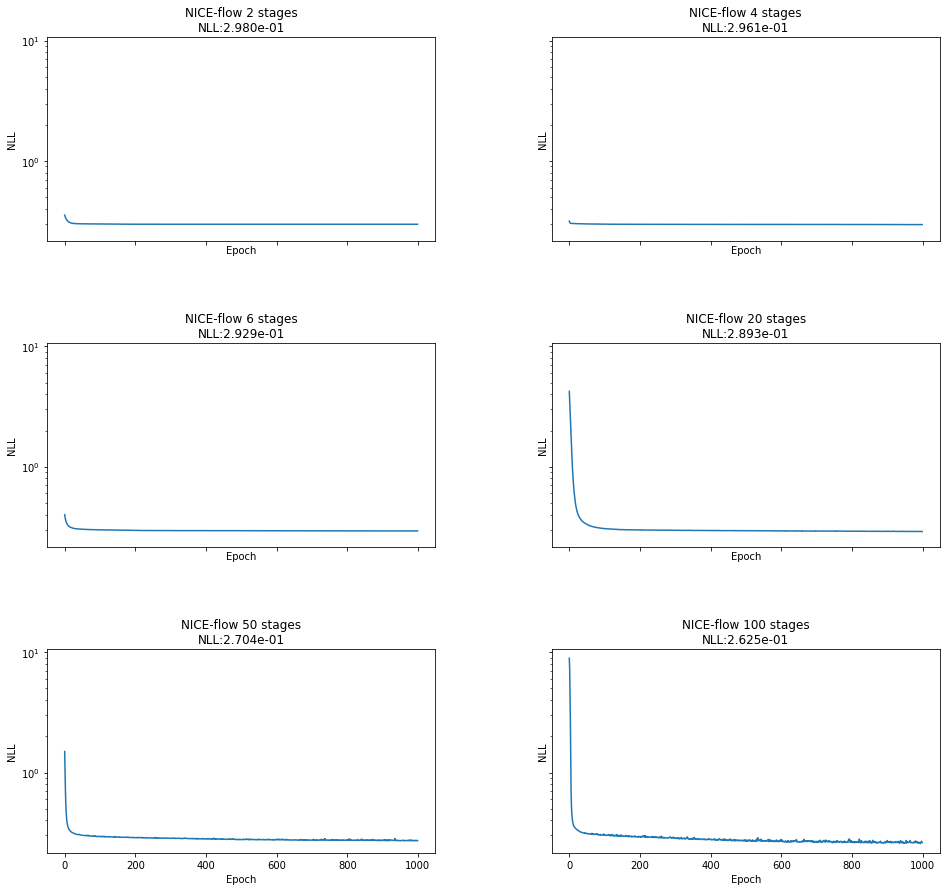

In [7]:
epochs = 1000


t0 = time.time()
nice_cal_2 = NiceCalibrator(val_logits, val_target, layers=2, hidden_size=[1],
                            version=3, epochs=epochs)
print('Fitted in {:.3f}s'.format(time.time()-t0))

t0 = time.time()
nice_cal_4 = NiceCalibrator(val_logits, val_target, layers=4, hidden_size=[1],
                            version=3, epochs=epochs)
print('Fitted in {:.3f}s'.format(time.time()-t0))

t0 = time.time()
nice_cal_6 = NiceCalibrator(val_logits, val_target, layers=6, hidden_size=[1],
                            version=3, epochs=epochs)
print('Fitted in {:.3f}s'.format(time.time()-t0))


t0 = time.time()
nice_cal_20 = NiceCalibrator(val_logits, val_target, layers=20, hidden_size=[1],
                             version=3, epochs=epochs)
print('Fitted in {:.3f}s'.format(time.time()-t0))


t0 = time.time()
nice_cal_50 = NiceCalibrator(val_logits, val_target, layers=50, hidden_size=[1],
                             version=3, epochs=epochs)
print('Fitted in {:.3f}s'.format(time.time()-t0))

t0 = time.time()
nice_cal_100 = NiceCalibrator(val_logits, val_target, layers=100, hidden_size=[1],
                              version=3, epochs=epochs)
print('Fitted in {:.3f}s'.format(time.time()-t0))

# Plot training NLL
fig, ax_arr = plt.subplots(3, 2, figsize=(16, 15), sharex='all', sharey='all', gridspec_kw={'hspace': 0.5, 'wspace': 0.3})

ax_arr[0, 0].plot(nice_cal_2.history.history['loss'])
ax_arr[0, 0].set_title('NICE-flow 2 stages\nNLL:{:.3e}'.format(neg_log_likelihood(nice_cal_2(val_logits), val_target)))
ax_arr[0, 0].set_ylabel('NLL')
ax_arr[0, 0].set_xlabel('Epoch')
ax_arr[0, 0].set_yscale('log')

ax_arr[0, 1].plot(nice_cal_4.history.history['loss'])
ax_arr[0, 1].set_title('NICE-flow 4 stages\nNLL:{:.3e}'.format(neg_log_likelihood(nice_cal_4(val_logits), val_target)))
ax_arr[0, 1].set_ylabel('NLL')
ax_arr[0, 1].set_xlabel('Epoch')
ax_arr[0, 1].set_yscale('log')

ax_arr[1, 0].plot(nice_cal_6.history.history['loss'])
ax_arr[1, 0].set_title('NICE-flow 6 stages\nNLL:{:.3e}'.format(neg_log_likelihood(nice_cal_6(val_logits), val_target)))
ax_arr[1, 0].set_ylabel('NLL')
ax_arr[1, 0].set_xlabel('Epoch')
ax_arr[1, 0].set_yscale('log')

ax_arr[1, 1].plot(nice_cal_20.history.history['loss'])
ax_arr[1, 1].set_title('NICE-flow 20 stages\nNLL:{:.3e}'.format(neg_log_likelihood(nice_cal_20(val_logits), val_target)))
ax_arr[1, 1].set_ylabel('NLL')
ax_arr[1, 1].set_xlabel('Epoch')
ax_arr[1, 1].set_yscale('log')

ax_arr[2, 0].plot(nice_cal_50.history.history['loss'])
ax_arr[2, 0].set_title('NICE-flow 50 stages\nNLL:{:.3e}'.format(neg_log_likelihood(nice_cal_50(val_logits), val_target)))
ax_arr[2, 0].set_ylabel('NLL')
ax_arr[2, 0].set_xlabel('Epoch')
ax_arr[2, 0].set_yscale('log')

ax_arr[2, 1].plot(nice_cal_100.history.history['loss'])
ax_arr[2, 1].set_title('NICE-flow 100 stages\nNLL:{:.3e}'.format(neg_log_likelihood(nice_cal_100(val_logits), val_target)))
ax_arr[2, 1].set_ylabel('NLL')
ax_arr[2, 1].set_xlabel('Epoch')
ax_arr[2, 1].set_yscale('log')

plt.show()

### Effect of number of layers on simplex

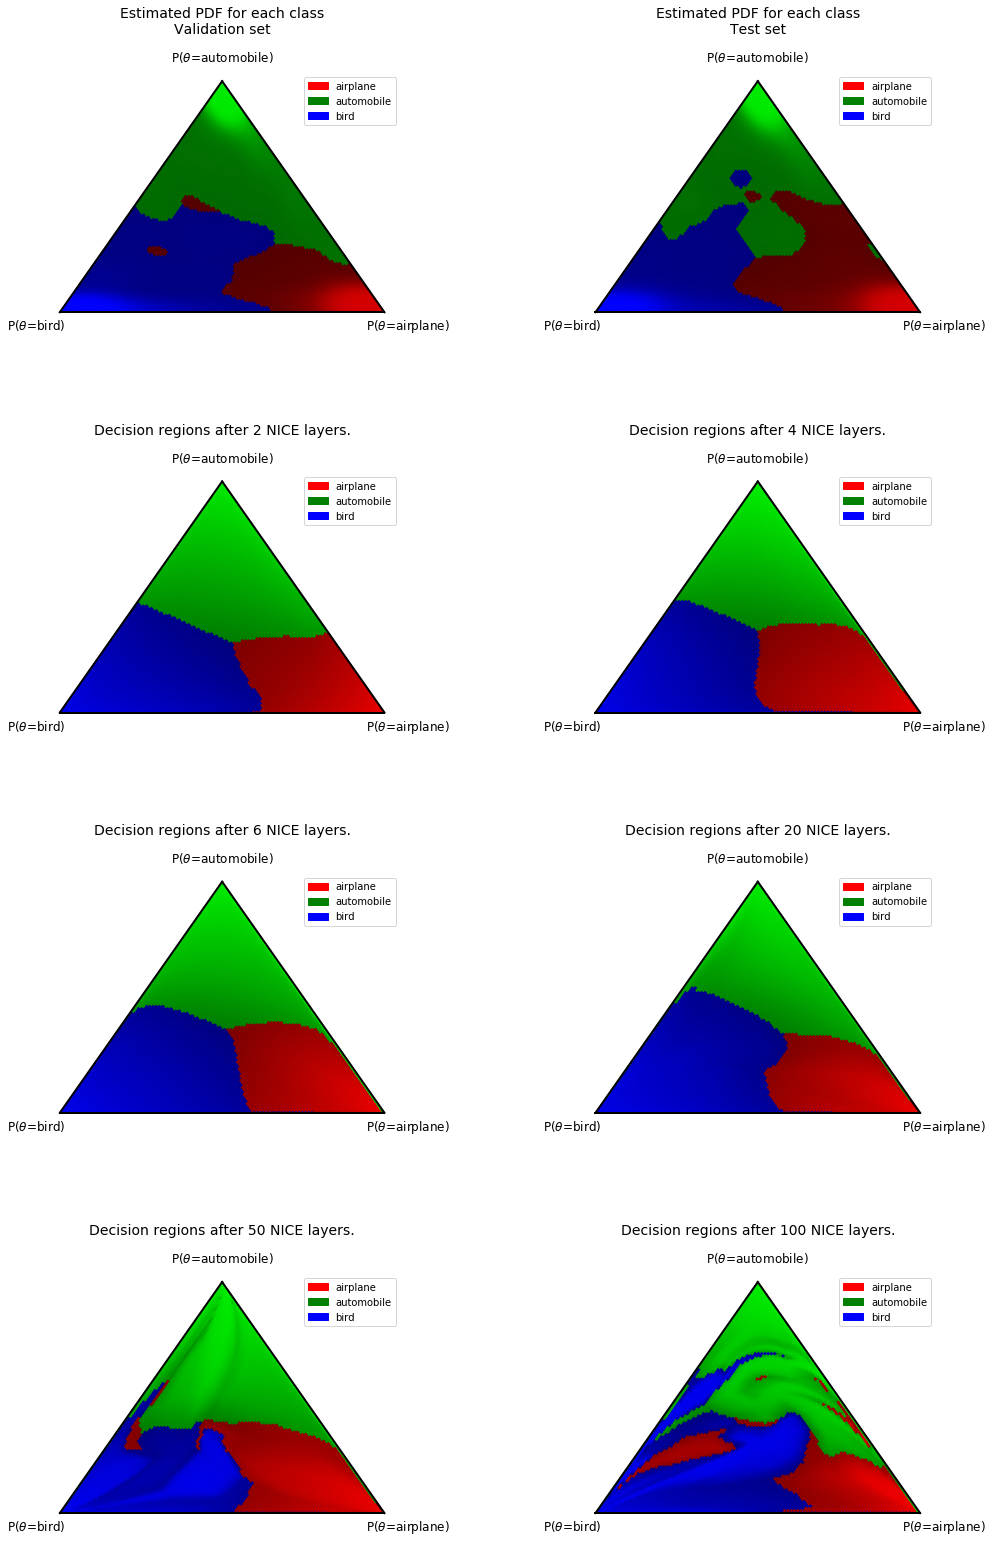

In [8]:
fig, ax_arr = plt.subplots(4, 2, figsize=(16, 27), gridspec_kw={'hspace': 0.5, 'wspace': 0.5})

ax_arr[0, 0] = plot_pdf_simplex(softmax(val_logits, axis=1), target=val_target, ax=ax_arr[0, 0], scale=100,
                             title='Estimated PDF for each class\nValidation set', fontsize=12, labels=list(ix2label.values()));
ax_arr[0, 1] = plot_pdf_simplex(softmax(test_logits, axis=1), target=test_target, ax=ax_arr[0, 1], scale=100,
                             title='Estimated PDF for each class\nTest set', fontsize=12, labels=list(ix2label.values()));


ax_arr[1, 0] = plot_cal_regions_ternary(nice_cal_2, ax=ax_arr[1, 0], scale=100, labels=list(ix2label.values()),
                                        title='Decision regions after 2 NICE layers.', fontsize=12);
ax_arr[1, 1] = plot_cal_regions_ternary(nice_cal_4, ax=ax_arr[1, 1], scale=100, labels=list(ix2label.values()),
                                        title='Decision regions after 4 NICE layers.', fontsize=12);
ax_arr[2, 0] = plot_cal_regions_ternary(nice_cal_6, ax=ax_arr[2, 0], scale=100, labels=list(ix2label.values()),
                                        title='Decision regions after 6 NICE layers.', fontsize=12);
ax_arr[2, 1] = plot_cal_regions_ternary(nice_cal_20, ax=ax_arr[2, 1], scale=100, labels=list(ix2label.values()),
                                        title='Decision regions after 20 NICE layers.', fontsize=12);
ax_arr[3, 0] = plot_cal_regions_ternary(nice_cal_50, ax=ax_arr[3, 0], scale=100, labels=list(ix2label.values()),
                                        title='Decision regions after 50 NICE layers.', fontsize=12);
ax_arr[3, 1] = plot_cal_regions_ternary(nice_cal_100, ax=ax_arr[3, 1], scale=100, labels=list(ix2label.values()),
                                        title='Decision regions after 100 NICE layers.', fontsize=12);
plt.show()